# Task

Let we have some system (Lorenz or pendulum) $S$, which is a model of the tatlin simulator, such that 

$$\vec{\phi}_{t+1} = S(\vec{\phi}_{t})$$

We want to describe $S$ by a linear transformation:

$$\vec{\phi}_{t+1} = A(\vec{\phi}_{t}) \cdot \vec{\phi}_{t}$$

because in this case we could analize a significance of $A$ elements and better understand what we are supposed to do next.

$A$ -- has to be RL Agent to show that RL is appropriate here.

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [2]:
from ddpg_agent import Agent

# Case 1

$\vec{\phi}_{t+1} = A(\vec{\phi}_{t})$

### Env

In [3]:
class PendulumEnvAR(gym.Env):
    def __init__(self, ar=2, a=1, phase=0, freq=1, dt=0.01, n_steps=1):
        self.initial_params = locals().copy()
        del self.initial_params['self']
        
        self.ar = ar
        self.dt = dt
        self.n_steps = n_steps
        self.i = 0
        
        self.a = a
        self.phase = phase
        self.freq = freq
        
        self.period = 2 * np.pi / self.freq
        self.points = np.arange(0, self.period, self.dt)
        
        self.state, self.expected_point = self._random_state()
        
    def _random_state(self):
        expected_point = np.random.choice(self.points)
        state = expected_point - np.arange(self.ar, 0, -1) * self.dt
        return self._sin(state), self._sin(expected_point)
    
    def get_seq(self):
        t_points = self.points
        states = []
        expected_points = []
        for t in t_points:
            expected_point = t
            state = expected_point - np.arange(self.ar, 0, -1) * self.dt
            states.append(self._sin(state))
            expected_points.append(self._sin(expected_point))
        return t_points, np.array(states), np.array(expected_points)
        
    def _sin(self, t):
        return self.a * np.sin(self.phase + self.freq * t)

    def step(self, action):

        # state
        self.i += 1

        # reward
        distance = np.linalg.norm(self.expected_point - action)
        reward = -distance

        # done
        done = self.i == self.n_steps
        
        # info
        info = {}
        
        # obs
        self.state, self.expected_point = self._random_state()
        obs = self.state

        return obs, reward, done, info
    
    def reset(self):
        self.__init__(**self.initial_params)
        obs = self.state
        return obs

    @property
    def observation_space(self):
        return spaces.Box(low=-self.a, high=self.a, shape=(self.ar,), dtype=np.float32)

    @property
    def action_space(self):
        return spaces.Box(low=-self.a, high=self.a, shape=(1,), dtype=np.float32)



In [4]:
env = PendulumEnvAR(ar=2, n_steps=10)
o, r, d, _ = env.step(env.expected_point)
assert r == 0
o, r, d, _ = env.step(-env.expected_point)
assert r < 0

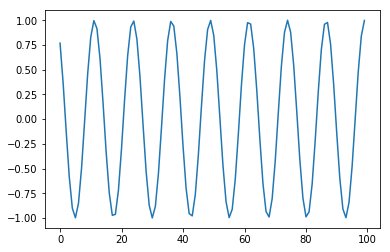

In [5]:
env = PendulumEnvAR(ar=100, n_steps=1, dt=0.5)
o, r, d, _ = env.step(env.expected_point)
plt.plot(np.arange(o.shape[0]), o)
plt.show()

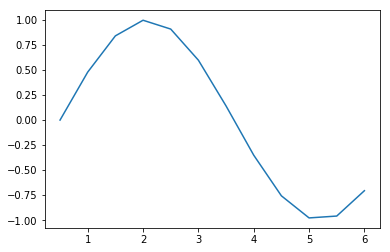

In [6]:
t, states, expected_points = env.get_seq()
plt.plot(t[1:], expected_points[:-1])
plt.show()

### DDPG

In [7]:
def ddpg(n_episodes=200, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            agent.reset()
            env.reset()
            t, states, expected_points = env.get_seq()
            # noise -- false
            actions = np.array([agent.act(s, add_noise=False)[0] for s in states])
            plt.plot(t[1:], expected_points[:-1])
            plt.plot(t[1:], actions[:-1])
            plt.show()
            
    return scores

### DDPG for dt=0.5

In [8]:
env = PendulumEnvAR(ar=4, n_steps=10, dt=0.5)
agent = Agent(state_size=4, action_size=1, random_seed=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: -3.83


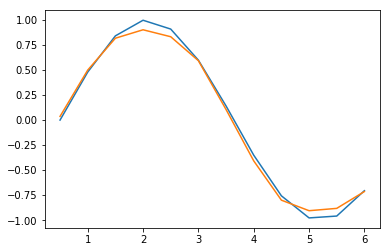

Episode 200	Average Score: -2.91


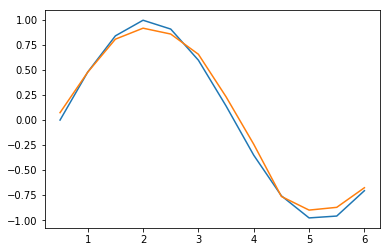

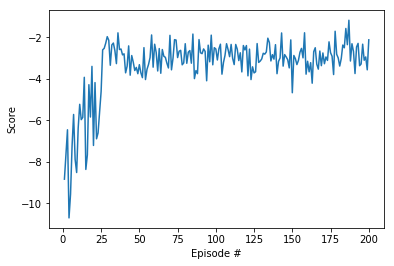

In [9]:
scores = ddpg(n_episodes=200, max_t=300, print_every=100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### DDPG for dt=0.01

In [10]:
env = PendulumEnvAR(ar=4, n_steps=10, dt=0.01)
agent = Agent(state_size=4, action_size=1, random_seed=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: -3.58


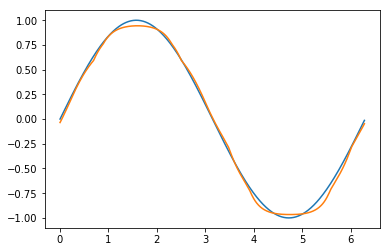

Episode 200	Average Score: -2.83


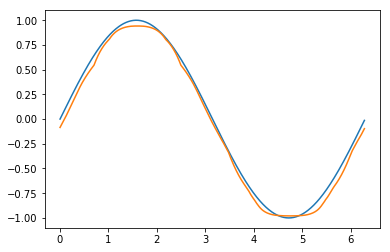

Episode 300	Average Score: -2.75


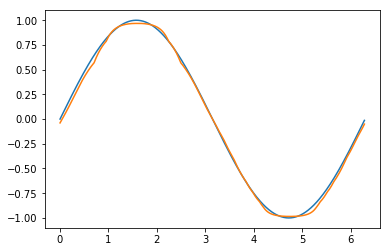

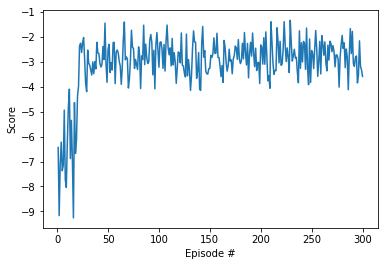

In [11]:
scores = ddpg(n_episodes=300, max_t=300, print_every=100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Case 2

$\vec{\phi}_{t+1} = A(\vec{\phi}_{t}) \cdot \vec{\phi}_{t}$

### Env

In [12]:
class PendulumEnvAR(gym.Env):
    def __init__(self, ar=2, a=1, phase=0, freq=1, dt=0.01, n_steps=1):
        self.initial_params = locals().copy()
        del self.initial_params['self']
        
        self.ar = ar
        self.dt = dt
        self.n_steps = n_steps
        self.i = 0
        
        self.a = a
        self.phase = phase
        self.freq = freq
        
        self.period = 2 * np.pi / self.freq
        self.points = np.arange(0, self.period, self.dt)
        
        self.state, self.expected_point = self._random_state()
        
    def _random_state(self):
        expected_point = np.random.choice(self.points)
        state = expected_point - np.arange(self.ar, 0, -1) * self.dt
        return self._sin(state), self._sin(expected_point)
    
    def get_seq(self):
        t_points = self.points
        states = []
        expected_points = []
        for t in t_points:
            expected_point = t
            state = expected_point - np.arange(self.ar, 0, -1) * self.dt
            states.append(self._sin(state))
            expected_points.append(self._sin(expected_point))
        return t_points, np.array(states), np.array(expected_points)
        
    def _sin(self, t):
        return self.a * np.sin(self.phase + self.freq * t)

    def step(self, action):

        # state
        self.i += 1

        # reward
        point = np.dot(action/100, self.state)
        distance = np.linalg.norm(self.expected_point - action)
        reward = -distance

        # done
        done = self.i == self.n_steps
        
        # info
        info = {}
        
        # obs
        self.state, self.expected_point = self._random_state()
        obs = self.state

        return obs, reward, done, info
    
    def reset(self):
        self.__init__(**self.initial_params)
        obs = self.state
        return obs

    @property
    def observation_space(self):
        return spaces.Box(low=-self.a, high=self.a, shape=(self.ar,), dtype=np.float32)

    @property
    def action_space(self):
        return spaces.Box(low=-self.a, high=self.a, shape=(self.ar,), dtype=np.float32)



In [13]:
env = PendulumEnvAR(ar=2, n_steps=10)
o, r, d, _ = env.step(env.expected_point)
assert r == 0
o, r, d, _ = env.step(-env.expected_point)
assert r < 0

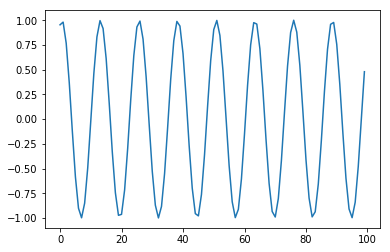

In [14]:
env = PendulumEnvAR(ar=100, n_steps=1, dt=0.5)
o, r, d, _ = env.step(env.expected_point)
plt.plot(np.arange(o.shape[0]), o)
plt.show()

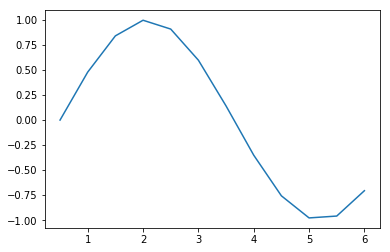

In [15]:
t, states, expected_points = env.get_seq()
plt.plot(t[1:], expected_points[:-1])
plt.show()

### DDPG

In [16]:
def ddpg(n_episodes=1000, max_t=300, print_every=200):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            agent.reset()
            env.reset()
            t, states, expected_points = env.get_seq()
            predicted_points = np.array([np.dot(agent.act(s, add_noise=False), s) for s in states])
            plt.plot(t[1:], expected_points[:-1])
            plt.plot(t[1:], predicted_points[:-1])
            plt.show()
            
    return scores

### DDPG for dt=0.5

In [17]:
env = PendulumEnvAR(ar=4, n_steps=10, dt=0.5)
agent = Agent(state_size=4, action_size=4, random_seed=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 200	Average Score: -7.49


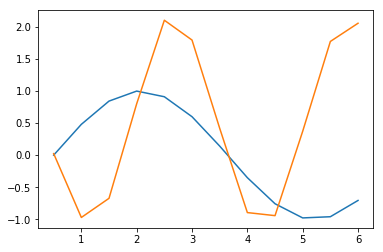

Episode 400	Average Score: -5.67


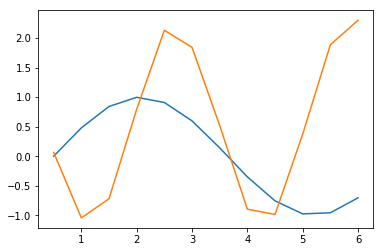

Episode 600	Average Score: -5.48


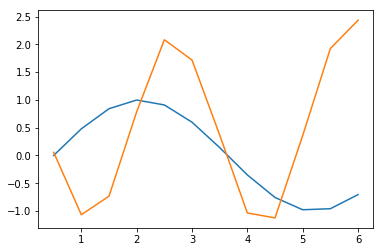

Episode 800	Average Score: -5.37


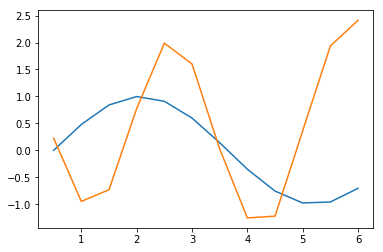

Episode 1000	Average Score: -5.40


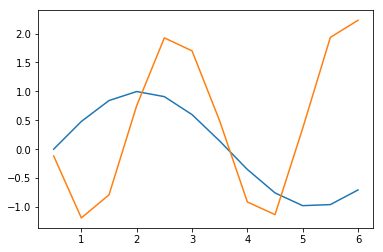

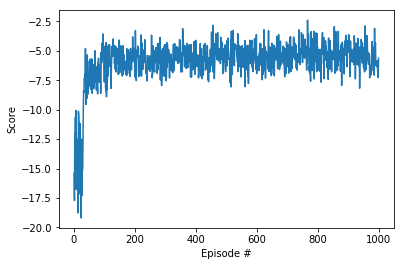

In [18]:
scores = ddpg(n_episodes=1000, max_t=300, print_every=200)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### DDPG for dt=0.01

In [19]:
env = PendulumEnvAR(ar=4, n_steps=10, dt=0.01)
agent = Agent(state_size=4, action_size=4, random_seed=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 200	Average Score: -6.95


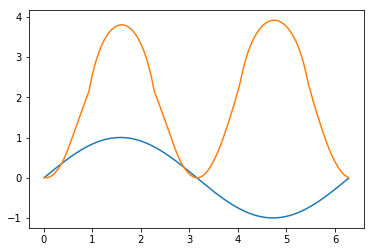

Episode 400	Average Score: -5.69


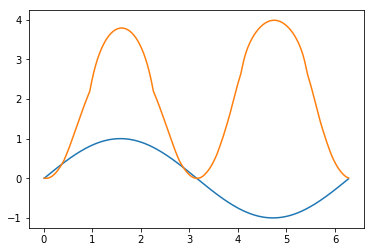

Episode 600	Average Score: -5.35


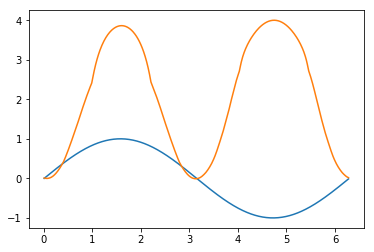

Episode 800	Average Score: -5.37


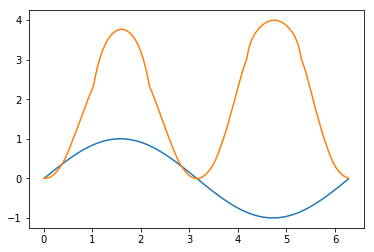

Episode 1000	Average Score: -5.62


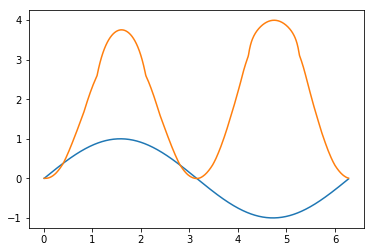

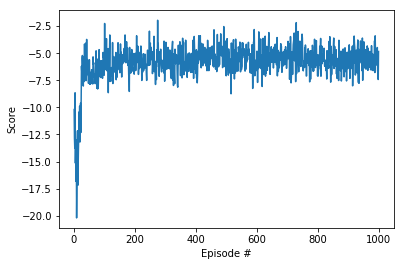

In [20]:
scores = ddpg(n_episodes=1000, max_t=300, print_every=200)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()